<a href="https://colab.research.google.com/github/karu-bee/AI-QUEST/blob/master/ASSESSMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x 
import google.colab
import googleapiclient.discovery
import googleapiclient.http
google.colab.auth.authenticate_user()
drive_service = googleapiclient.discovery.build('drive', 'v3')
def uploadgdrive(nparray, filename):
  df = pd.DataFrame(nparray)
  df.to_csv( filename +'.csv', index = False) #, header = False)
  saving_filename =  filename + '.csv'
  file_metadata = {'name': saving_filename,'mimeType': 'application/octet-stream'}
  media = googleapiclient.http.MediaFileUpload(saving_filename,mimetype='application/octet-stream',resumable=True)
  created = drive_service.files().create(body=file_metadata,media_body=media,fields='id').execute()
def dlgdrive(upload_filename):
    file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')
    file_id = None
    for file in file_list:
      if file.get('name') == upload_filename:
        file_id = file.get('id')
        break
    if file_id is None:
      print(upload_filename + ' が見つかりません.')
    else:
      with open(upload_filename, 'wb') as f:
        request = drive_service.files().get_media(fileId=file_id)
        media = googleapiclient.http.MediaIoBaseDownload(f, request)
        done = False
        while not done:
          progress_status, done = media.next_chunk()
          print(100*progress_status.progress(), end="")
          print("%完了")
      print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')
#USAGE
#uploadgdrive(pred_train_2, 'pred_train_2')
#uploadgdrive(pred_test_2, 'pred_test_2') 
#dlgdrive('pred_train_2.csv')
#dlgdrive('pred_test_2.csv')  

TensorFlow 1.x selected.


In [7]:
########################### train.csv ########################################
upload_filename = 'train.csv'
file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')
# ファイル ID を取得します。
file_id = None
for file in file_list:
  if file.get('name') == upload_filename:
    file_id = file.get('id')
    break
if file_id is None:
  # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
  print(upload_filename + ' が見つかりません.')
else:
  # colab 環境へファイルをアップロードします。
  with open(upload_filename, 'wb') as f:
    request = drive_service.files().get_media(fileId=file_id)
    media = googleapiclient.http.MediaIoBaseDownload(f, request)
    done = False
    while not done:
      progress_status, done = media.next_chunk()
      print(100*progress_status.progress(), end="")
      print("%完了")
  print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')
########################### test.csv ########################################
upload_filename = 'test.csv'
file_list = drive_service.files().list(q="name='" + upload_filename + "'").execute().get('files')
# ファイル ID を取得します。
file_id = None
for file in file_list:
  if file.get('name') == upload_filename:
    file_id = file.get('id')
    break
if file_id is None:
  # ファイル ID を取得できなかった場合はエラーメッセージを出力します。
  print(upload_filename + ' が見つかりません.')
else:
  # colab 環境へファイルをアップロードします。
  with open(upload_filename, 'wb') as f:
    request = drive_service.files().get_media(fileId=file_id)
    media = googleapiclient.http.MediaIoBaseDownload(f, request)
    done = False
    while not done:
      progress_status, done = media.next_chunk()
      print(100*progress_status.progress(), end="")
      print("%完了")
  print('GoogleドライブからColab環境へのファイル取り込みが完了しました.')

100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.
100.0%完了
GoogleドライブからColab環境へのファイル取り込みが完了しました.


In [8]:
# 前処理
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### データーロード ###
dfx_train_org = pd.read_csv('train.csv')
dfx_test_org = pd.read_csv('test.csv')
print(dfx_train_org.shape) 
print(dfx_test_org.shape)
testID = dfx_test_org.iloc[:,0].values.astype(int)
# Train+Test結合
dfx_t = pd.concat([dfx_train_org, dfx_test_org], sort=False)
print(dfx_t.shape)
dfx_t.head(1)

(55583, 29)
(18528, 28)
(74111, 29)


,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,2016-07-27,t,f,NaN,2016-07-13,f,2016-07-27,33.788931,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0


カラム	ヘッダ名称	データ型	説明<br>
0	id	int	インデックスとして使用<br>
1	accommodates	int	収容可能人数<br>
2	amenities	char	アメニティ<br>
3	bathrooms	float	風呂数<br>
4	bed_type	char	ベッドの種類<br>
5	bedrooms	float	ベッドルーム数<br>
6	beds	float	ベッド数<br>
7	cancellation_policy	char	キャンセルポリシー<br>
8	city	char	都市<br>
9	cleaning_fee	int	クリーニング料金を含むか<br>
10	description	char	説明<br>
11	first_review	char	最初のレビュー日<br>
12	host_has_profile_pic	int	ホストの写真があるかどうか<br>
13	host_identity_verified	int	ホストの身元確認が取れているか<br>
14	host_response_rate	char	ホストの返信率<br>
15	host_since	char	ホストの登録日<br>
16	instant_bookable	char	即時予約可能か<br>
17	last_review	char	最後のレビュー日<br>
18	latitude	float	緯度<br>
19	longitude	float	経度<br>
20	name	char	物件名<br>
21	neighbourhood	char	近隣情報<br>
22	number_of_reviews	int	レビュー数<br>
23	property_type	char	物件の種類<br>
24	review_scores_rating	float	レビュースコア<br>
25	room_type	char	部屋の種類<br>
26	thumbnail_url	char	サムネイル画像リンク<br>
27	zipcode	int	郵便番号<br>
28	y	float	宿泊価格<br>

In [14]:

# 不要データ削除
dfx_to =  dfx_t.drop(['first_review', 'last_review', 
                      'amenities', 'name','description', 
                      'thumbnail_url', 'zipcode'
                      ], axis=1)
print(dfx_to.shape)
#日付変換
d = pd.to_datetime(dfx_to['host_since'], format='%Y-%m-%d')
dfx_to['host_since'] = d.dt.year
#欠損値確認
def kesson_table(df):
  null_val0 = df.isnull()
  null_val = null_val0.sum()
  percent = 100 * null_val / len(df)
  kesson_table = pd.concat([null_val, percent], axis=1)
  kesson_table_ren_columns=kesson_table.rename(columns = {0 : '欠損数', 1 : '%'})
  return kesson_table_ren_columns
#print(kesson_table(dfx_to))
dfx_tot = dfx_to.fillna(-1)
print(dfx_tot.shape)
# One-Hotエンコーディング
dfx_tota = pd.get_dummies(dfx_tot, columns=[ 'host_response_rate','neighbourhood', 
                                            'bed_type','cancellation_policy','city','cleaning_fee',
                                            'host_has_profile_pic','host_identity_verified',
                                            'instant_bookable','property_type','room_type'
                                            ])

#カテゴリ変数にラベルエンコーディングを適用する
from sklearn.preprocessing import LabelEncoder
for c in [ ]:
  le=LabelEncoder()
  le.fit(dfx_tota[c])
  dfx_tota[c] = le.transform(dfx_tota[c])  

print(dfx_tota.shape)
# 縦に連結したデータをモデル作成用と予測対象用に切り戻す
train_d = dfx_tota[0:55583].copy()
test_d = dfx_tota[55583:].copy()
print(train_d.shape)
print(test_d.shape)
# 目的変数と説明変数に分ける
dfy_train = train_d.loc[:,'y']
dfx_train = train_d.drop(['y'],axis=1)
dfx_test = test_d.drop(['y'],axis=1)
print(dfx_train.shape)
print(dfx_test.shape)
train_x = dfx_train.values
x_test = dfx_test.values
train_y = dfy_train.values
print('train_x.shape',train_x.shape)
print('x_test.shape',x_test.shape)
print('train_y.shape',train_y.shape)
#hold-out法
tr_x, va_x, tr_y, va_y = train_test_split(train_x, train_y, test_size=0.25, random_state=71,shuffle=True)
print('tr_x.shape',tr_x.shape)
print('tr_y.shape',tr_y.shape)
print('va_x.shape',va_x.shape)
print('va_y.shape',va_y.shape)

(74111, 22)
(74111, 22)
(74111, 776)
(55583, 776)
(18528, 776)
(55583, 775)
(18528, 775)
train_x.shape (55583, 775)
x_test.shape (18528, 775)
train_y.shape (55583,)
tr_x.shape (41687, 775)
tr_y.shape (41687,)
va_x.shape (13896, 775)
va_y.shape (13896,)


In [16]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

# ニューラルネットによるモデル
class MLP:
    def __init__(self):
        self.model = None
        self.scaler = None

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.scaler = StandardScaler()
        self.scaler.fit(tr_x)
        tr_x = self.scaler.transform(tr_x)
        va_x = self.scaler.transform(va_x)
        print(tr_x.shape,va_x.shape)

        model = Sequential()
        model.add(Dense(64, activation='relu', input_shape=(tr_x.shape[1],)))
        model.add(Dropout(0.2))
        model.add(Dense(32))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        model.add(Dense(16))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        
        def step_decay(epoch):
          x = 0.01
          if epoch >= 25: x = 0.005
          if epoch >= 50: x = 0.001
          if epoch >= 75: x = 0.0005
          return x
              
        lr_decay = LearningRateScheduler(step_decay)
        early_stopping = EarlyStopping(patience=10, verbose=1) 
        model.compile(optimizer=Adam(lr=0.01), loss='mse', metrics=['mae'])
        history = model.fit(tr_x, tr_y,   #トレーニングデータ
                            batch_size=1024, #バッチサイズの指定
                            epochs=1000,   #エポック数の指定
                            verbose=1,    #ログ出力の指定
                            validation_data=(va_x, va_y), #テストデータ
                            callbacks=[
                                       lr_decay, 
                                       early_stopping
                                       ]
                            )
        
        fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
        def plot_history_loss(fit):
            axL.plot(fit.history['loss'],label="loss for training")
            axL.plot(fit.history['val_loss'],label="loss for validation")
            axL.set_title('model loss')
            axL.set_xlabel('epoch')
            axL.set_ylabel('loss')
            axL.legend(loc='upper right')
        def plot_history_acc(fit):
            axR.plot(fit.history['accuracy'],label="acc for training")
            axR.plot(fit.history['val_accuracy'],label="acc for validation")
            axR.set_title('model accuracy')
            axR.set_xlabel('epoch')
            axR.set_ylabel('accuracy')
            axR.legend(loc='lower right')
        plot_history_loss(history)
        #plot_history_acc(history)
        self.model = model

    def predict(self, x):
        x = self.scaler.transform(x)
        pred = self.model.predict(x)
        return pred

Using TensorFlow backend.


(41687, 775) (13896, 775)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 41687 samples, validate on 13896 samples
Epoch 1/1000
41687/41687 [==============================] - 1s 28us/sample - loss: 52943.3125 - mean_absolute_error: 158.3130 - val_loss: 42720.6405 - val_mean_absolute_error: 145.3958
Epoch 2/1000
41687/41687 [==============================] - 1s 19us/sample - loss: 48784.3595 - mean_absolute_error: 151.0816 - val_loss: 38134.6593 - val_mean_absolute_error: 137.1277
Epoch 3/1000
41687/41687 [==============================] - 1s 18us/sample - loss: 40538.9290 - mean_absolute_error: 135.7523 - val_loss: 24665.9105 - val_mean_absolute_error: 110.1115
Epoch 4/1000
41687/41687 [==============================] - 1s 18us/sample - loss: 29886.4373 - mean_absolute_error: 111.4226 - val_loss: 21806.4958 - val_mean_absolute_error: 104.9902
Epoch 5/1000
41687/41687 [==============================] - 1s 18us/sample - loss: 20737.6860 - mean_ab

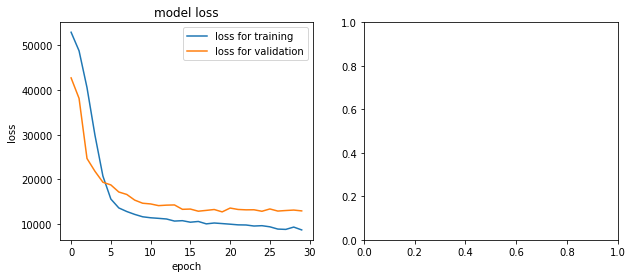

In [17]:
# 学習
model = MLP()
model.fit(tr_x, tr_y, va_x, va_y)
# 評価
from sklearn.metrics import mean_squared_error
va_pred = model.predict(va_x)
print( "RMSE =", np.sqrt(mean_squared_error(va_y, va_pred)))

In [18]:
y_pred = model.predict(x_test)
print(y_pred.shape)
# PassengerIDと予測結果を張り合わせて提出用CSVファイル作成
id = testID.reshape(-1,1)
out = np.concatenate([id.astype(int), y_pred], axis=1)
submission = pd.DataFrame(out)
submission

(18528, 1)


,0,1
0,0.0,321.947052
1,1.0,142.604782
2,2.0,100.395195
3,3.0,137.339462
4,4.0,174.259659
...,...,...
18523,18523.0,191.091019
18524,18524.0,133.324753
18525,18525.0,152.704437
18526,18526.0,137.897644


In [19]:
submission.to_csv('submission.csv' , index = False, header = False)
saving_filename = "submission.csv"
file_metadata = {
  'name': saving_filename,
  'mimeType': 'application/octet-stream'
}
media = googleapiclient.http.MediaFileUpload(saving_filename, 
                        mimetype='application/octet-stream',
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()